In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os

# Set better plotting defaults
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

# Load data
build_df = pd.read_csv('build_metrics.csv')
results_df = pd.read_csv('results.csv')

print("Build metrics shape:", build_df.shape)
print("Results shape:", results_df.shape)
print("\nBuild metrics columns:", build_df.columns.tolist())
print("Results columns:", results_df.columns.tolist())


/home/jabcross/repos/iara/experiment/cholesky/instances


In [ ]:
# Parse configuration names to extract parameters
def parse_config_name(config_name):
    """Parse config_name like '256_1_sequential' into components"""
    parts = config_name.rsplit('_', 1)  # Split from right to get scheduler
    scheduler = parts[1]
    matrix_blocks = parts[0].split('_')
    matrix_size = int(matrix_blocks[0])
    num_blocks = int(matrix_blocks[1])
    return matrix_size, num_blocks, scheduler

# Add parsed columns to build_df
build_df[['matrix_size', 'num_blocks', 'scheduler']] = build_df['config_name'].apply(
    lambda x: pd.Series(parse_config_name(x))
)

print("\nParsed build_df:")
print(build_df[['config_name', 'matrix_size', 'num_blocks', 'scheduler']].head())


In [ ]:
# Stacked bar chart for binary sizes by section (.text, .data, .bss)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Binary Size Breakdown by Scheduler', fontsize=14, fontweight='bold')

configs = [
    ('256', 1, 'Matrix: 256×256, 1 block'),
    ('256', 4, 'Matrix: 256×256, 4 blocks'),
    ('1024', 1, 'Matrix: 1024×1024, 1 block'),
    ('1024', 4, 'Matrix: 1024×1024, 4 blocks'),
]

schedulers = ['sequential', 'omp-task', 'virtual-fifo']
colors = {'text_size': '#2E86AB', 'data_size': '#A23B72', 'bss_size': '#F18F01'}
section_labels = {'text_size': '.text', 'data_size': '.data', 'bss_size': '.bss'}

for idx, (matrix_size, num_blocks, title) in enumerate(configs):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for this configuration
    config_data = build_df[
        (build_df['matrix_size'] == int(matrix_size)) & 
        (build_df['num_blocks'] == num_blocks)
    ].sort_values('scheduler')
    
    x_pos = np.arange(len(schedulers))
    width = 0.6
    
    # Stack bars for each section
    bottom = np.zeros(len(schedulers))
    for section in ['text_size', 'data_size', 'bss_size']:
        values = [config_data[config_data['scheduler'] == s][section].values[0] 
                  for s in schedulers]
        ax.bar(x_pos, values, width, bottom=bottom, 
               label=section_labels[section], color=colors[section])
        bottom += values
    
    # Add total size labels on top of bars
    for i, scheduler in enumerate(schedulers):
        total = config_data[config_data['scheduler'] == scheduler]['total_size'].values[0]
        ax.text(i, total, f'{total/1024:.1f} KB', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Binary Size (bytes)')
    ax.set_title(title)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(schedulers, rotation=15, ha='right')
    ax.legend(loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Use log scale if the difference is too large
    if config_data['total_size'].max() / config_data['total_size'].min() > 10:
        ax.set_yscale('log')
        ax.set_ylabel('Binary Size (bytes, log scale)')

plt.tight_layout()
plt.savefig('binary_size_stacked.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Compilation time comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Group by matrix_size and num_blocks for x-axis
build_df['config_label'] = build_df.apply(
    lambda row: f"{row['matrix_size']}×{row['matrix_size']}\n{row['num_blocks']} block{'s' if row['num_blocks'] > 1 else ''}", 
    axis=1
)

# Pivot for grouped bar chart
pivot_data = build_df.pivot_table(
    index='config_label', 
    columns='scheduler', 
    values='compile_time'
)

# Reorder to match our preferred scheduler order
pivot_data = pivot_data[schedulers]

# Plot grouped bars
x_pos = np.arange(len(pivot_data))
width = 0.25

for i, scheduler in enumerate(schedulers):
    offset = width * (i - 1)
    bars = ax.bar(x_pos + offset, pivot_data[scheduler], width, 
                   label=scheduler, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Configuration')
ax.set_ylabel('Compilation Time (seconds)')
ax.set_title('Compilation Time by Scheduler and Configuration', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(pivot_data.index)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('compile_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Runtime performance: wall time (aggregated with mean and std)
results_agg = results_df.groupby(['matrix_size', 'num_blocks', 'scheduler']).agg({
    'wall_time': ['mean', 'std'],
    'max_rss_kb': ['mean', 'std']
}).reset_index()

results_agg.columns = ['matrix_size', 'num_blocks', 'scheduler', 
                       'wall_time_mean', 'wall_time_std', 
                       'max_rss_mean', 'max_rss_std']

results_agg['config_label'] = results_agg.apply(
    lambda row: f"{row['matrix_size']}×{row['matrix_size']}\n{row['num_blocks']} block{'s' if row['num_blocks'] > 1 else ''}", 
    axis=1
)

# Plot wall time with error bars
fig, ax = plt.subplots(figsize=(12, 6))

pivot_time = results_agg.pivot_table(
    index='config_label', 
    columns='scheduler', 
    values='wall_time_mean'
)[schedulers]

pivot_std = results_agg.pivot_table(
    index='config_label', 
    columns='scheduler', 
    values='wall_time_std'
)[schedulers]

x_pos = np.arange(len(pivot_time))
width = 0.25

for i, scheduler in enumerate(schedulers):
    offset = width * (i - 1)
    ax.bar(x_pos + offset, pivot_time[scheduler], width, 
           yerr=pivot_std[scheduler], label=scheduler, 
           alpha=0.8, capsize=5)

ax.set_xlabel('Configuration')
ax.set_ylabel('Wall Time (seconds)')
ax.set_title('Runtime Performance by Scheduler and Configuration', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(pivot_time.index)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('runtime_performance.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Memory usage (Max RSS)
fig, ax = plt.subplots(figsize=(12, 6))

pivot_rss = results_agg.pivot_table(
    index='config_label', 
    columns='scheduler', 
    values='max_rss_mean'
)[schedulers]

pivot_rss_std = results_agg.pivot_table(
    index='config_label', 
    columns='scheduler', 
    values='max_rss_std'
)[schedulers]

x_pos = np.arange(len(pivot_rss))
width = 0.25

for i, scheduler in enumerate(schedulers):
    offset = width * (i - 1)
    bars = ax.bar(x_pos + offset, pivot_rss[scheduler] / 1024, width,  # Convert to MB
                   yerr=pivot_rss_std[scheduler] / 1024, label=scheduler, 
                   alpha=0.8, capsize=5)

ax.set_xlabel('Configuration')
ax.set_ylabel('Max RSS (MB)')
ax.set_title('Memory Usage by Scheduler and Configuration', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(pivot_rss.index)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('memory_usage.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Summary table
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print("\nBinary Size Overhead (vs Sequential):")
for matrix_size, num_blocks in [(256, 1), (256, 4), (1024, 1), (1024, 4)]:
    config_data = build_df[
        (build_df['matrix_size'] == matrix_size) & 
        (build_df['num_blocks'] == num_blocks)
    ]
    seq_size = config_data[config_data['scheduler'] == 'sequential']['total_size'].values[0]
    omp_size = config_data[config_data['scheduler'] == 'omp-task']['total_size'].values[0]
    vf_size = config_data[config_data['scheduler'] == 'virtual-fifo']['total_size'].values[0]
    
    print(f"\n{matrix_size}×{matrix_size}, {num_blocks} block(s):")
    print(f"  Sequential:    {seq_size:>8,} bytes")
    print(f"  OMP Task:      {omp_size:>8,} bytes ({omp_size/seq_size:>5.2f}x)")
    print(f"  Virtual FIFO:  {vf_size:>8,} bytes ({vf_size/seq_size:>5.2f}x)")

print("\n" + "=" * 80)
print("Compilation Time Overhead (vs Sequential):")
for matrix_size, num_blocks in [(256, 1), (256, 4), (1024, 1), (1024, 4)]:
    config_data = build_df[
        (build_df['matrix_size'] == matrix_size) & 
        (build_df['num_blocks'] == num_blocks)
    ]
    seq_time = config_data[config_data['scheduler'] == 'sequential']['compile_time'].values[0]
    omp_time = config_data[config_data['scheduler'] == 'omp-task']['compile_time'].values[0]
    vf_time = config_data[config_data['scheduler'] == 'virtual-fifo']['compile_time'].values[0]
    
    print(f"\n{matrix_size}×{matrix_size}, {num_blocks} block(s):")
    print(f"  Sequential:    {seq_time:>6.2f}s")
    print(f"  OMP Task:      {omp_time:>6.2f}s ({omp_time/seq_time:>5.2f}x)")
    print(f"  Virtual FIFO:  {vf_time:>6.2f}s ({vf_time/seq_time:>5.2f}x)")


In [29]:
datasets = [df[df['matrix-size'] == ms] for ms in sorted(df['matrix-size'].unique())]

datasets

[     matrix-size  num-blocks  block-size  block_size_bytes     scheduler  \
 180         2048          16         128            131072      omp-task   
 181         2048          16         128            131072      omp-task   
 182         2048          16         128            131072      omp-task   
 183         2048          16         128            131072    sequential   
 184         2048          16         128            131072    sequential   
 185         2048          16         128            131072    sequential   
 186         2048          16         128            131072  virtual-fifo   
 187         2048          16         128            131072  virtual-fifo   
 188         2048          16         128            131072  virtual-fifo   
 189         2048           1        2048          33554432      omp-task   
 190         2048           1        2048          33554432      omp-task   
 191         2048           1        2048          33554432      omp-task   

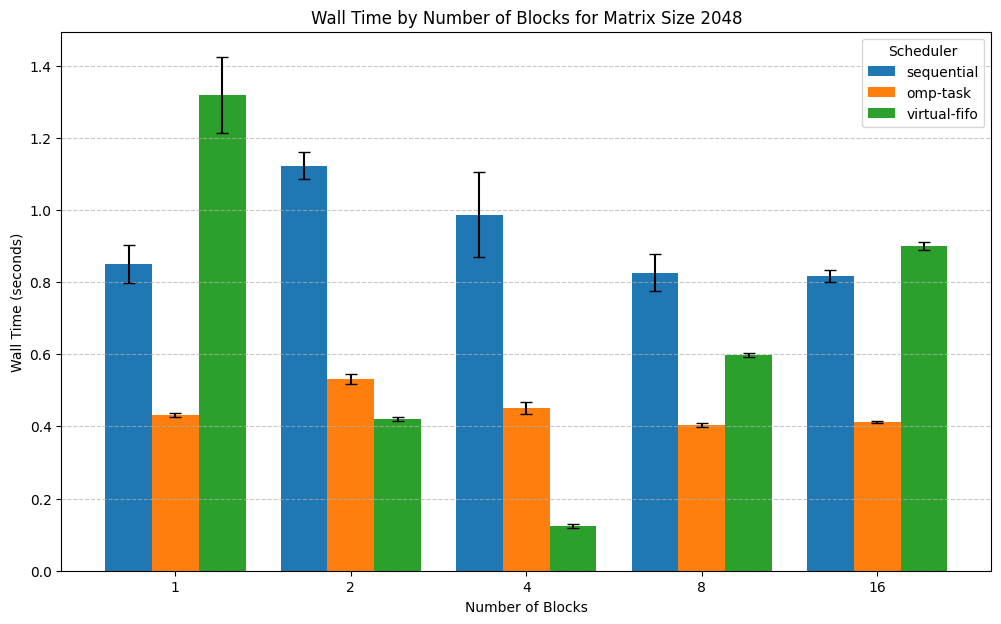

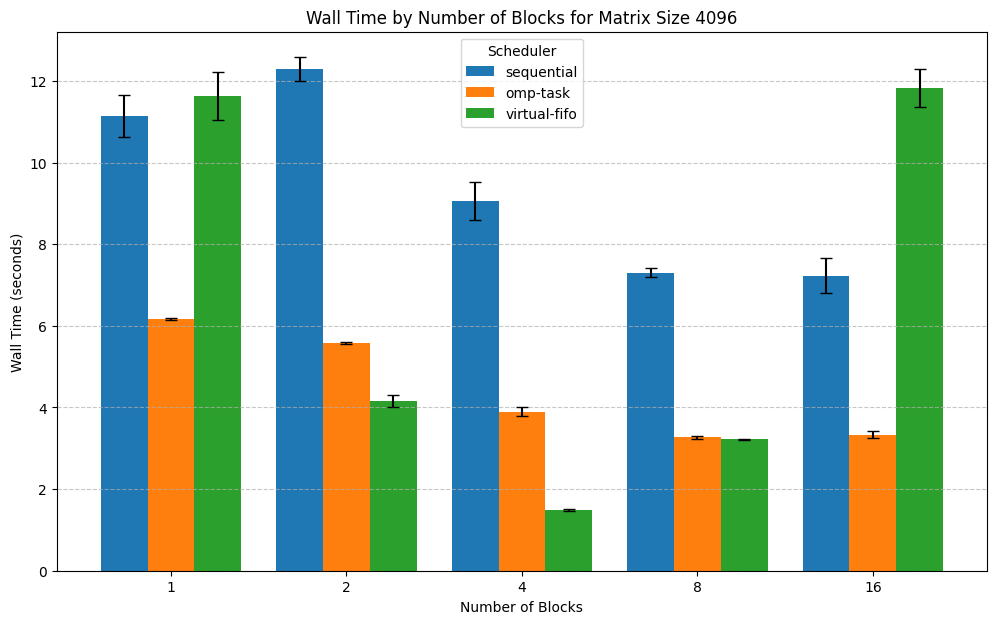

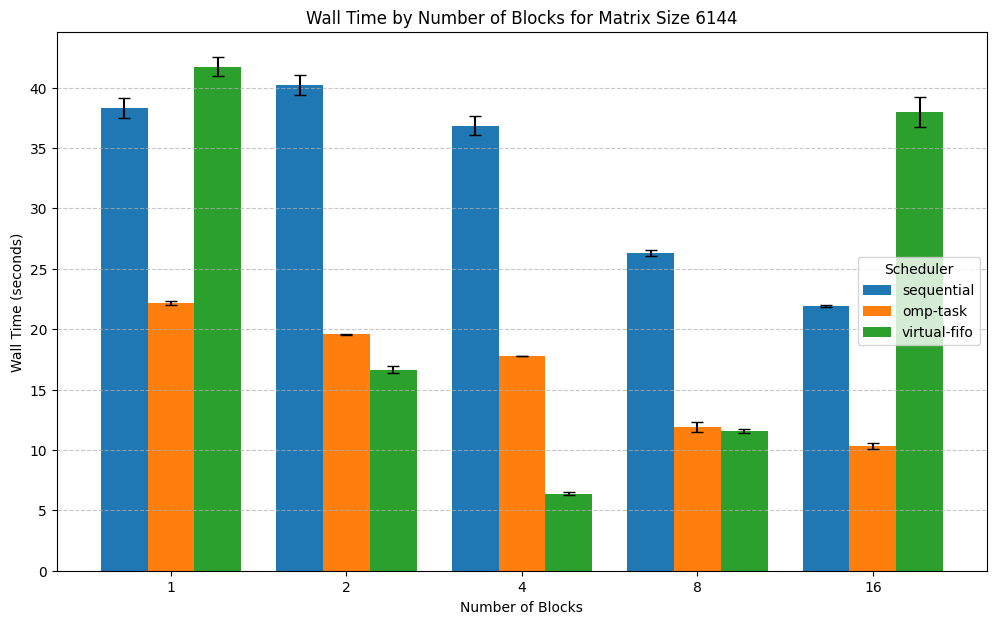

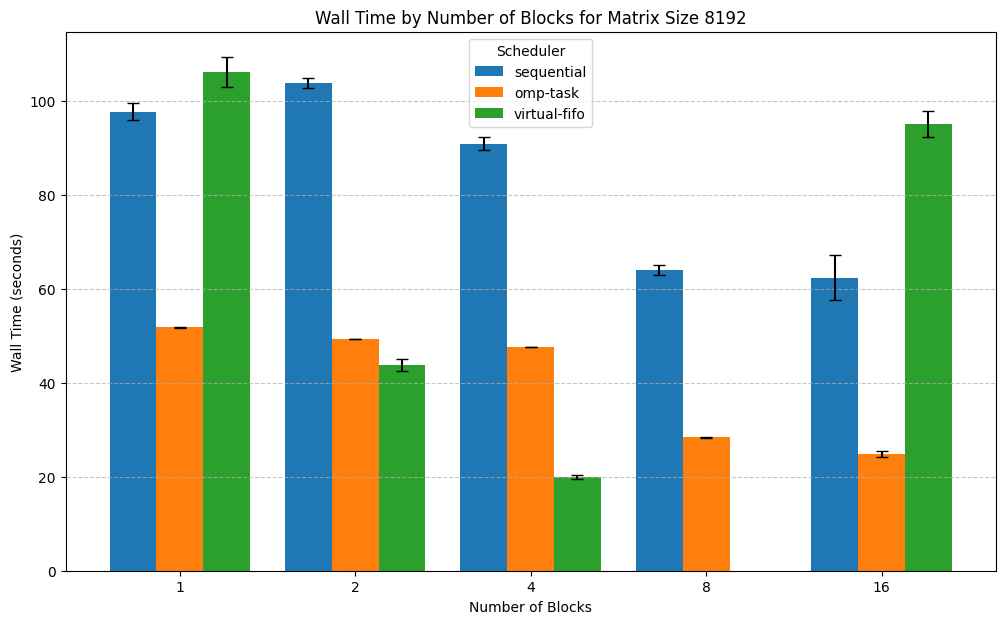

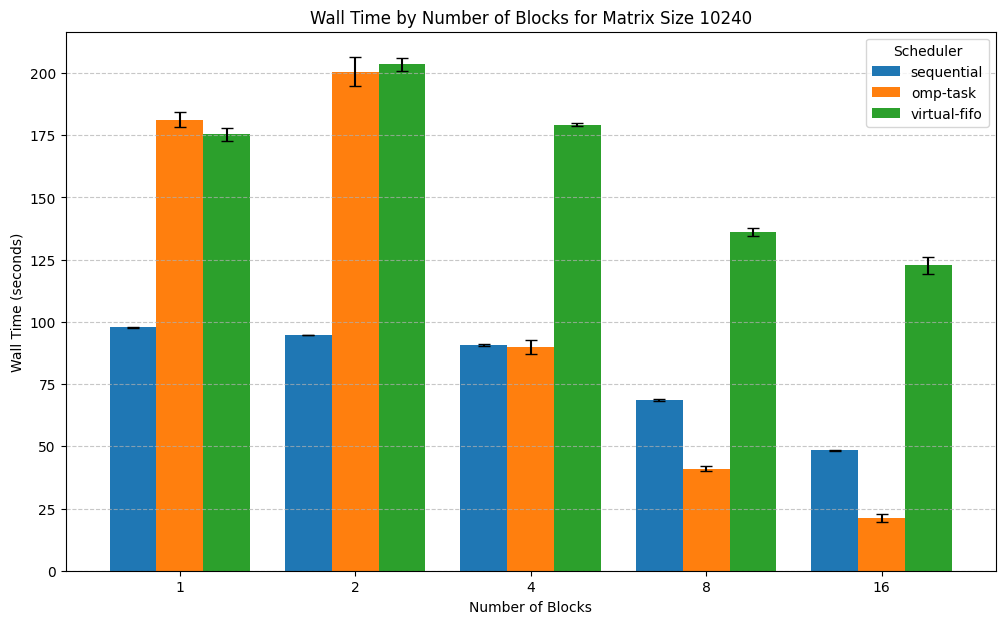

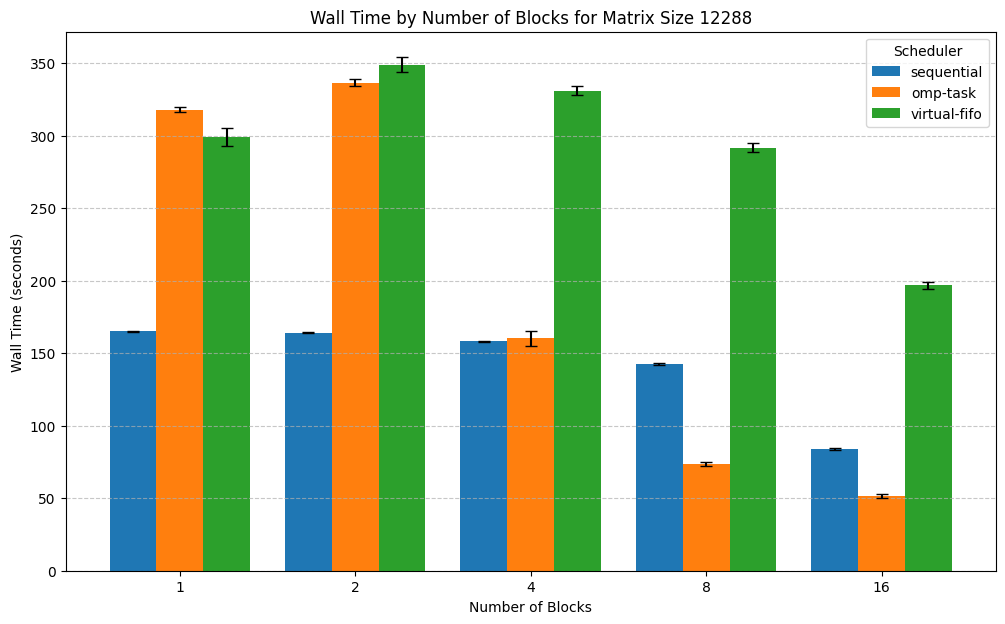

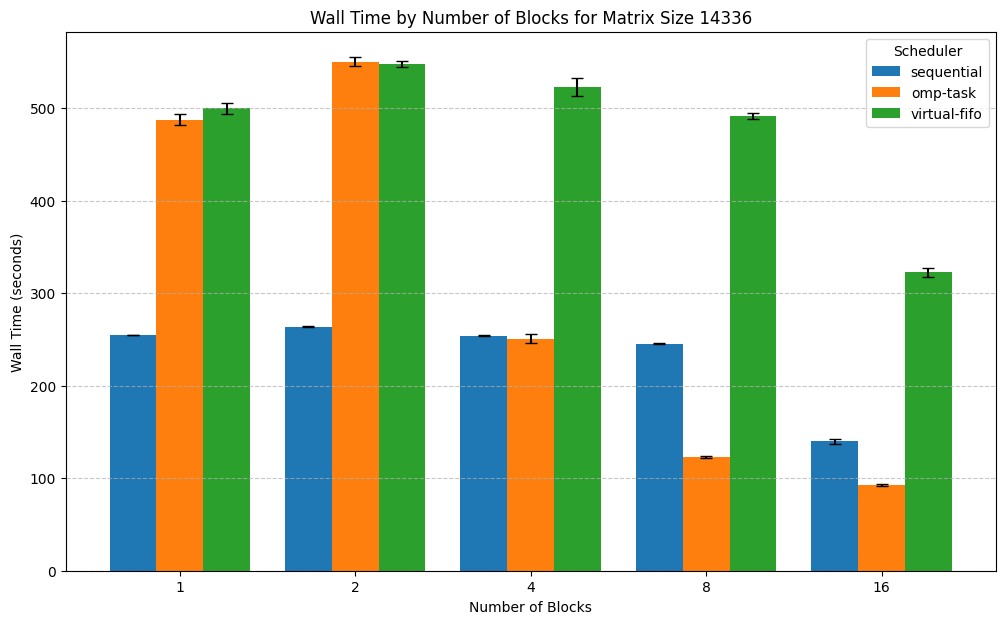

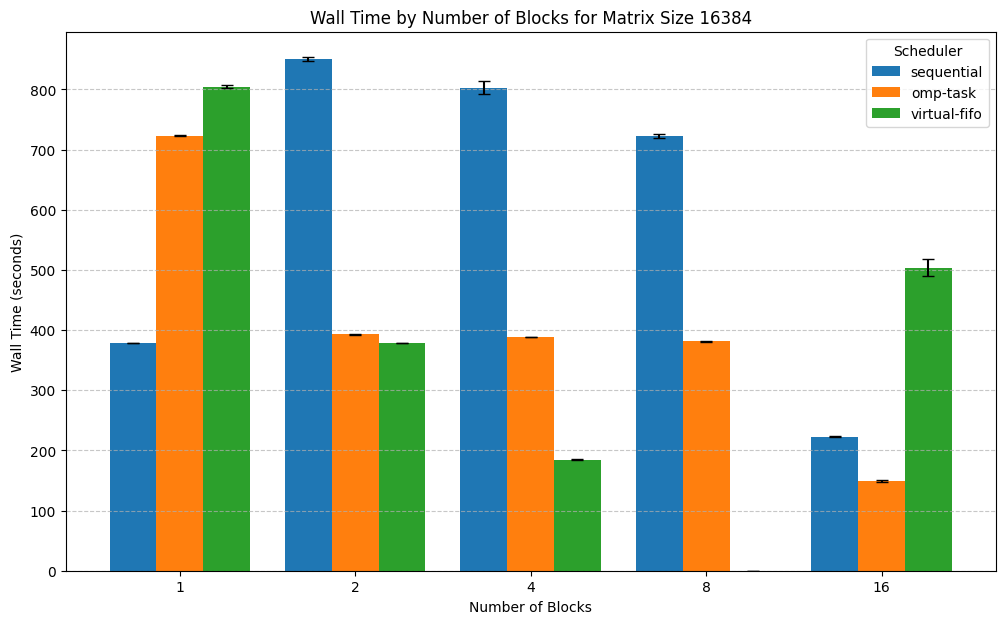

In [34]:
for data in datasets:

  # Group by 'num-blocks' and 'scheduler', then calculate the mean wall-time
  grouped = data.groupby(['num-blocks', 'scheduler'])['wall-time'].mean().unstack()
  
  # Define the desired order of schedulers
  scheduler_order = ['sequential', 'omp-task', 'virtual-fifo']
  
  # Reorder the columns to match the desired scheduler order
  grouped = grouped.reindex(columns=[s for s in scheduler_order if s in grouped.columns])

  # Calculate error bars using statistical bootstrap
  errors = data.groupby(['num-blocks', 'scheduler'])['wall-time'].apply(
      lambda x: np.std([np.mean(x.sample(frac=1, replace=True)) for _ in range(100)])
  ).unstack()

  # Re-order columns to match the plot order if necessary
  errors = errors[grouped.columns]

  # Create a bar plot with error bars
  ax = grouped.plot(kind='bar', yerr=errors, figsize=(12, 7), width=0.8, capsize=4)
  
  # Set plot title and labels
  matrix_size = data['matrix-size'].iloc[0]
  plt.title(f'Wall Time by Number of Blocks for Matrix Size {matrix_size}')
  plt.ylabel('Wall Time (seconds)')
  plt.xlabel('Number of Blocks')
  plt.xticks(rotation=0)
  plt.legend(title='Scheduler')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  
  # Show the plot
  plt.show()

In [ ]:

df = pd.read_csv('measurement.csv')

schedulers = ["sequential","omp-task","virtual-fifo"]


grouped = df.groupby(['matrix-size', 'num-blocks', 'scheduler'])['wall-time'].mean().unstack('scheduler')
# grouped = grouped.drop(8192)
grouped.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Wall Time')
plt.title('Wall Time by Matrix Size and Scheduler')
plt.legend(title='Scheduler')

df.plot(kind='bar')

plt.xlabel(df["scheduler"])

# plt.show()

# grouped = df.groupby(df.columns[3]).size()
# grouped.plot(kind='bar')
# plt.xlabel(df.columns[3])
# plt.ylabel('Count')
# plt.title('Bar Chart Grouped by {}'.format(df.columns[4]))
# plt.show()
